In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Hyperparameters
batch_size = 3000
lr = 0.0002
epochs = 50
noise_dim = 100




NameError: name 'transforms' is not defined

In [10]:
# Initialize models
generator = Generator(noise_dim, 784)
discriminator = Discriminator(784)

# Loss and optimizers
criterion = nn.BCELoss()
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = optim.Adam(generator.parameters(), lr=lr)


In [11]:
for epoch in range(epochs):
    for batch_idx, (real_images, _) in enumerate(train_loader):
        batch_size = real_images.size(0)
        
        # Real and fake labels
        real_labels = torch.ones(batch_size, 1)
        fake_labels = torch.zeros(batch_size, 1)
        
        # Train discriminator
        outputs = discriminator(real_images)
        d_loss_real = criterion(outputs, real_labels)
        real_score = outputs
        
        noise = torch.randn(batch_size, noise_dim)
        fake_images = generator(noise)
        outputs = discriminator(fake_images.detach())
        d_loss_fake = criterion(outputs, fake_labels)
        fake_score = outputs
        
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        # Train generator
        outputs = discriminator(fake_images)
        g_loss = criterion(outputs, real_labels)
        
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        
        if (batch_idx+1) % 200 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Step [{batch_idx+1}/{len(train_loader)}], d_loss: {d_loss.item():.4f}, g_loss: {g_loss.item():.4f}, D(x): {real_score.mean().item():.2f}, D(G(z)): {fake_score.mean().item():.2f}')


Epoch [1/50], Step [200/938], d_loss: 0.2706, g_loss: 2.5051, D(x): 1.00, D(G(z)): 0.23
Epoch [1/50], Step [400/938], d_loss: 0.2675, g_loss: 10.0963, D(x): 0.89, D(G(z)): 0.01
Epoch [1/50], Step [600/938], d_loss: 0.0336, g_loss: 9.6138, D(x): 0.99, D(G(z)): 0.02
Epoch [1/50], Step [800/938], d_loss: 1.1722, g_loss: 0.9607, D(x): 0.59, D(G(z)): 0.45
Epoch [2/50], Step [200/938], d_loss: 1.0271, g_loss: 1.5888, D(x): 0.75, D(G(z)): 0.36
Epoch [2/50], Step [400/938], d_loss: 1.1496, g_loss: 2.2873, D(x): 0.64, D(G(z)): 0.24
Epoch [2/50], Step [600/938], d_loss: 1.3171, g_loss: 1.6597, D(x): 0.70, D(G(z)): 0.46
Epoch [2/50], Step [800/938], d_loss: 0.3081, g_loss: 2.3326, D(x): 0.95, D(G(z)): 0.17
Epoch [3/50], Step [200/938], d_loss: 0.7673, g_loss: 2.4993, D(x): 0.72, D(G(z)): 0.15
Epoch [3/50], Step [400/938], d_loss: 0.0604, g_loss: 5.3336, D(x): 0.98, D(G(z)): 0.03
Epoch [3/50], Step [600/938], d_loss: 0.1565, g_loss: 4.5396, D(x): 0.92, D(G(z)): 0.02
Epoch [3/50], Step [800/938], d

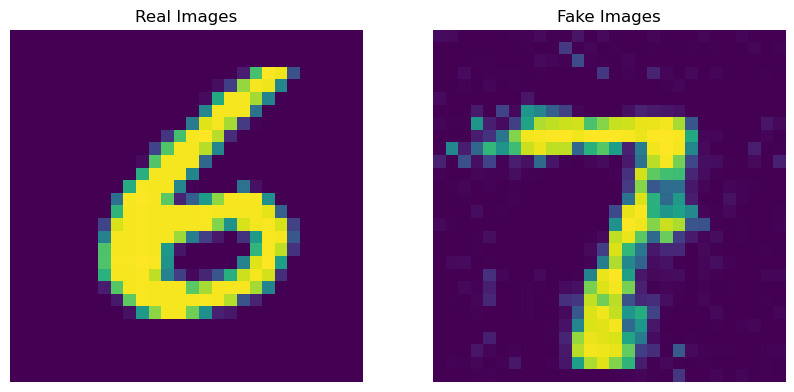

In [16]:
# Generate images from noise, using the generator network.
with torch.no_grad():
    noise = torch.randn(batch_size, noise_dim)
    generated_images = generator(noise).cpu().view(-1, 28, 28)

# Plot the real images
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(real_images[0].view(-1, 28, 28).numpy(), (1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(generated_images[0].view(-1, 28, 28).numpy(), (1,2,0)))
plt.show()


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

# Hyperparameters
batch_size = 3000
lr = 0.0002
epochs = 50
noise_dim = 100

# Data loader
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_loader = DataLoader(datasets.MNIST('./data', train=True, download=True, transform=transform), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(datasets.MNIST('./data', train=False, download=True, transform=transform), batch_size=batch_size, shuffle=True)


# Generator Model
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(64 * 28 * 28, 512)
        
        self.action_mean = nn.Linear(512, 3)  # For x, y, brightness
        self.action_std = nn.Linear(512, 3)  # For x, y, brightness

    def forward(self, x):
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = x.view(-1, 64 * 28 * 28)
        x = self.fc1(x)
        x = nn.ReLU()(x)
        
        action_mean = self.action_mean(x)
        action_std = self.action_std(x)
        action_std = nn.Softplus()(action_std)  # Ensure standard deviation is positive
        
        return action_mean, action_std
    
# Discriminator Model
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(32 * 28 * 28, 10)  # 10 classes for MNIST

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 32 * 28 * 28)
        x = self.fc(x)
        return x

# Instantiate Models
generator = Generator()
discriminator = Discriminator()

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=0.0001)
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001)

In [2]:
from RL_utils import sample_action_and_logprob, add_brightness_to_batch_images

# Loss Function
criterion = nn.CrossEntropyLoss()

# Early Stopping Parameters
patience = 10  # Number of epochs to wait for improvement
best_test_accuracy = 0.0  # Best test accuracy
counter = 0  # Counter for non-improvement epochs

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

g_learning_rate = [0.0001, 0.0002, 0.0005, 0.001, 0.002]
d_learning_rate = [0.00005, 0.0001, 0.0002, 0.0005, 0.001, 0.002]

for g_lr in g_learning_rate:
    for d_lr in d_learning_rate:
        print(f"Training with generator learning rate: {g_lr}, discriminator learning rate: {d_lr}")
        best_test_accuracy = 0.0
        counter = 0

        # Instantiate Models
        generator = Generator().to(device)
        discriminator = Discriminator().to(device)

        # Optimizers
        g_optimizer = optim.Adam(generator.parameters(), lr=g_lr)
        d_optimizer = optim.Adam(discriminator.parameters(), lr=d_lr)

        # Training Loop
        for epoch in range(1000):  # Example Epochs
            total_d_loss = 0
            total_g_loss = 0
            correct_labels = 0
            total_labels = 0
            
            for i, (images, labels) in enumerate(train_loader):  # Assuming train_loader is defined and provides images and labels
                images, labels = images.to(device), labels.to(device)
                action_mean, action_std = generator(images)

                actions, log_probs = sample_action_and_logprob(action_mean, action_std)

                adv_images = add_brightness_to_batch_images(images, actions)

                # Zero Gradients
                d_optimizer.zero_grad()

                # Forward Pass through Discriminator
                adv_outputs = discriminator(adv_images)

                # Calculate Loss
                d_loss = criterion(adv_outputs, labels)

                # Backward Pass
                d_loss.backward()
                d_optimizer.step()

                # Zero Gradients
                g_optimizer.zero_grad()

                g_loss = -torch.mean(log_probs) * d_loss.detach()  # Detach d_loss to avoid computing gradients

                # Update Generator based on Reward
                g_loss.backward()
                g_optimizer.step()

                total_d_loss += d_loss.item()
                total_g_loss += g_loss.item()

                # Calculate the number of correct labels
                _, predicted = torch.max(adv_outputs, 1)
                correct_labels += (predicted == labels).sum().item()
                total_labels += labels.size(0)
            
            # Calculate training accuracy
            train_accuracy = 100 * correct_labels / total_labels

            # Calculate test accuracy
            correct = 0
            total = 0
            with torch.no_grad():
                for images, labels in test_loader:
                    images, labels = images.to(device), labels.to(device)
                    outputs = discriminator(images)
                    _, predicted = torch.max(outputs, 1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)
            test_accuracy = 100 * correct / total

            # Early Stopping
            if test_accuracy > best_test_accuracy:
                best_test_accuracy = test_accuracy
                counter = 0  # Reset counter
            else:
                counter += 1

            if counter >= patience:
                print("Early Stopping triggered.")
                break  # Stop training

            print(f"Epoch[{epoch+1}], d_loss: {total_d_loss/len(train_loader):.4f}, g_loss: {total_g_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")


/home/daehwa/anaconda3/envs/VerificationDev/lib/python3.10/site-packages/torch/cuda/__init__.py:107: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343995026/work/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Training with generator learning rate: 0.0001, discriminator learning rate: 5e-05
Epoch[1], d_loss: 1.6818, g_loss: 1.4862, Train Accuracy: 59.81%, Test Accuracy: 79.89%
Epoch[2], d_loss: 0.9247, g_loss: 0.2604, Train Accuracy: 81.37%, Test Accuracy: 84.67%
Epoch[3], d_loss: 0.6680, g_loss: 0.9684, Train Accuracy: 85.06%, Test Accuracy: 86.90%
Epoch[4], d_loss: 0.5580, g_loss: 0.8569, Train Accuracy: 86.78%, Test Accuracy: 88.37%
Epoch[5], d_loss: 0.4961, g_loss: 0.6712, Train Accuracy: 87.81%, Test Accuracy: 88.70%
Epoch[6], d_loss: 0.4567, g_loss: 0.5794, Train Accuracy: 88.47%, Test Accuracy: 89.54%
Epoch[7], d_loss: 0.4272, g_loss: 0.5583, Train Accuracy: 88.95%, Test Accuracy: 89.93%
Epoch[8], d_loss: 0.4058, g_loss: 0.5647, Train Accuracy: 89.33%, Test Accuracy: 90.17%
Epoch[9], d_loss: 0.3894, g_loss: 0.5897, Train Accuracy: 89.61%, Test Accuracy: 90.43%
Epoch[10], d_loss: 0.3755, g_loss: 0.5939, Train Accuracy: 89.85%, Test Accuracy: 90.69%
Epoch[11], d_loss: 0.3639, g_loss: 0.

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# CNN Model Definition
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(32 * 28 * 28, 10)  # 10 classes for MNIST

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 32 * 28 * 28)
        x = self.fc(x)
        return x

# Hyperparameters
batch_size = 64
epochs = 5
learning_rates = [i*0.0001 for i in range(1,10)]  # 여러 learning rate를 리스트로 정의

# Data Loading and Preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Training Loop for each Learning Rate
for learning_rate in learning_rates:  # 각 learning rate에 대해 반복
    print(f"Training with learning rate: {learning_rate}")

    # Model, Loss Function, Optimizer
    model = CNN()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # Training Loop
    for epoch in range(epochs):
        total_loss = 0
        correct = 0
        total = 0

        for i, (images, labels) in enumerate(train_loader):
            # Zero Gradients
            optimizer.zero_grad()

            # Forward Pass
            outputs = model(images)

            # Compute Loss
            loss = criterion(outputs, labels)

            # Backward Pass
            loss.backward()

            # Update Weights
            optimizer.step()

            total_loss += loss.item()

            # Compute Training Accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        avg_loss = total_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        # Compute Test Accuracy
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)
        test_accuracy = 100 * correct / total

        print(f"Epoch[{epoch+1}/{epochs}], Loss: {avg_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%")


Training with learning rate: 0.0001
Epoch[1/5], Loss: 0.4114, Train Accuracy: 88.11%, Test Accuracy: 91.05%
Epoch[2/5], Loss: 0.3152, Train Accuracy: 90.89%, Test Accuracy: 90.42%
Epoch[3/5], Loss: 0.2998, Train Accuracy: 91.35%, Test Accuracy: 91.58%
Epoch[4/5], Loss: 0.2895, Train Accuracy: 91.80%, Test Accuracy: 92.34%
Epoch[5/5], Loss: 0.2813, Train Accuracy: 92.06%, Test Accuracy: 91.25%
Training with learning rate: 0.0002
Epoch[1/5], Loss: 0.3919, Train Accuracy: 88.48%, Test Accuracy: 90.92%
Epoch[2/5], Loss: 0.3095, Train Accuracy: 91.24%, Test Accuracy: 91.82%
Epoch[3/5], Loss: 0.2932, Train Accuracy: 91.75%, Test Accuracy: 91.70%
Epoch[4/5], Loss: 0.2837, Train Accuracy: 92.02%, Test Accuracy: 91.91%
Epoch[5/5], Loss: 0.2778, Train Accuracy: 92.15%, Test Accuracy: 91.76%
Training with learning rate: 0.00030000000000000003
Epoch[1/5], Loss: 0.3885, Train Accuracy: 88.68%, Test Accuracy: 91.20%
Epoch[2/5], Loss: 0.3062, Train Accuracy: 91.25%, Test Accuracy: 91.89%
Epoch[3/5], 